In [1]:
import pandas as pd
import sqlite3
import numpy as np
from datetime import datetime
import os
import logging
from pprint import pprint

import plotly.express as px
import plotly.graph_objects as go

import gym
import gym.spaces

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (11.5,6)
plt.style.use('ggplot')

logger = logging.getLogger(__name__)

import scipy.optimize as sco
from scipy import stats

plt.style.use('dark_background')

In [2]:
db_link ="/home/mateusz/Desktop/Moje_repo/My-Data-Science-repository/Stock_data_project/mWIG40/WIG40/WIG40/WIG.db"
conn = sqlite3.connect(db_link)

df = pd.read_sql('SELECT * FROM WIG',
            conn)

dates = [datetime.strptime(x, "%d-%m-%Y") for x in df["date"]]
df["date"] = dates

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466749 entries, 0 to 466748
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    466749 non-null  datetime64[ns]
 1   ticker  466749 non-null  object        
 2   open    466749 non-null  float64       
 3   MAX     466749 non-null  float64       
 4   MIN     466749 non-null  float64       
 5   close   466749 non-null  float64       
 6   volume  466749 non-null  float64       
 7   trade   466749 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 28.5+ MB


In [4]:
df.loc[df["ticker"]==df.ticker.unique()[0]].set_index("date")

,ticker,open,MAX,MIN,close,volume,trade
date,,,,,,,
2022-01-14,MAGNA POLONIA SPOLKA AKCYJNA,3.170,3.175,3.055,3.170,31747.0,98868.0
2022-01-13,MAGNA POLONIA SPOLKA AKCYJNA,3.200,3.200,3.140,3.170,10047.0,31692.0
2022-01-12,MAGNA POLONIA SPOLKA AKCYJNA,3.180,3.190,3.115,3.190,15092.0,47669.0
2022-01-11,MAGNA POLONIA SPOLKA AKCYJNA,3.140,3.190,3.100,3.100,21381.0,66695.0
2022-01-10,MAGNA POLONIA SPOLKA AKCYJNA,3.250,3.270,3.100,3.190,36051.0,114582.0
...,...,...,...,...,...,...,...
2022-03-18,MAGNA POLONIA SPOLKA AKCYJNA,3.375,3.870,3.325,3.680,131768.0,476476.0
2022-03-17,MAGNA POLONIA SPOLKA AKCYJNA,3.305,3.400,3.210,3.325,27326.0,90980.0
2022-03-16,MAGNA POLONIA SPOLKA AKCYJNA,3.235,3.350,3.195,3.305,47518.0,155514.0


In [5]:
df_list = []
for i in df.ticker.unique():
    df_x = df.loc[df["ticker"]==i] 
    df_x.name = i
    df_x=df_x.drop_duplicates()
    df_to_append=df_x.set_index("date")
    df_list.append(df_to_append[["ticker","open", "MAX", "MIN", "close", "trade"]])
    
df_list.sort(key=lambda x:len(x), reverse=True)
[(df.ticker.iloc[0],df.index[-1], df.index[0]) for df in df_list]


dfs1= [df for df in df_list if df.index.min()<=datetime.strptime('01-01-2019', "%d-%m-%Y") and 
      df.index.max()>=datetime.strptime('18-02-2022', "%d-%m-%Y")]

print(len(df_list))
print(len(dfs1))
print()

index_list_lengh = [[len(df.index), df["ticker"].iloc[0]] for df in dfs1]
max_index = 0
max_count = 0
for index, value in enumerate(index_list_lengh):
    max_count_value = value[0]
    max_index_ = index
    if max_count_value>max_count:
        max_index = max_index_
        max_count = max_count_value

mi = dfs1[max_index].index.copy()
print(mi)
for i in range(len(dfs1)):
    name = dfs1[i]["ticker"].iloc[0]
    df_list[i]=dfs1[i].reindex(mi)#, method="pad")

347
323

DatetimeIndex(['2022-01-14', '2022-01-13', '2022-01-12', '2022-01-11',
               '2022-01-10', '2022-01-07', '2022-01-05', '2022-01-04',
               '2022-01-03', '2021-12-30',
               ...
               '2022-02-24', '2022-02-23', '2022-02-22', '2022-02-21',
               '2022-02-18', '2022-03-18', '2022-03-17', '2022-03-16',
               '2022-03-15', '2022-03-14'],
              dtype='datetime64[ns]', name='date', length=1553, freq=None)


In [6]:
keys = [df["ticker"].iloc[0] for df in dfs1]
dfs1 = [df.drop(columns=["ticker"]) for df in dfs1]

In [7]:
df3 = pd.concat(dfs1, axis=1, keys=keys, names=['Pair','Price'])


In [8]:
print('cropped from', len(df3))
t=max([min(df1.index) for df1 in dfs1])
df3=df3[df3.index>t]
print('to',len(df3))

cropped from 1533
to 791


In [9]:
df3 = df3.fillna(method="pad")
# replace rest
df3.replace(np.nan, 0, inplace=True)
# df.unstack()
df3=df3.astype(np.float32)
df3.head()

Pair       BIOTON SPOLKA AKCYJNA                              \
Price                       open   MAX   MIN close     trade   
date                                                           
2018-12-18                  5.36  5.39  5.30  5.33  198032.0   
2018-12-19                  5.33  5.33  5.22  5.25  397124.0   
2018-12-20                  5.22  5.25  5.00  5.02  474136.0   
2018-12-21                  5.00  5.04  4.92  4.93  415031.0   
2018-12-27                  4.92  5.08  4.92  5.05  135316.0   

Pair       STALEXPORT AUTOSTRADY SPOLKA AKCYJNA                              \
Price                                      open   MAX   MIN close     trade   
date                                                                          
2018-12-18                                 3.20  3.26  3.19  3.21  205689.0   
2018-12-19                                 3.20  3.30  3.20  3.25  541348.0   
2018-12-20                                 3.24  3.26  3.20  3.26  459730.0   
2018-12-21                                 3.21  3.25  3.21  3.25  167343.0   
2018-12-27                                 3.26  3.30  3.25  3.27  449825.0   

Pair        ... RESBUD SE                           EUROHOLD BULGARIA AD       \
Price       ...      open   MAX   MIN close   trade                 open  MAX   
date        ...                                                                 
2018-12-18  ...      0.19  0.19  0.19  0.19  1915.0                  0.0  0.0   
2018-12-19  ...      0.18  0.18  0.16  0.16  4364.0                  0.0  0.0   
2018-12-20  ...      0.17  0.17  0.17  0.17  2703.0                  0.0  0.0   
2018-12-21  ...      0.15  0.16  0.15  0.16  4332.0                  0.0  0.0   
2018-12-27  ...      0.17  0.17  0.17  0.17  2797.0                  0.0  0.0   

Pair                         
Price       MIN close trade  
date                         
2018-12-18  0.0   0.0   0.0  
2018-12-19  0.0   0.0   0.0  
2018-12-20  0.0   0.0   0.0  
2018-12-21  0.0   0.0   0.0  
2018-12-27  0.0   0.0   0.0  

[5 rows x 1310 columns]

In [10]:
df3.head()

Pair       BIOTON SPOLKA AKCYJNA                              \
Price                       open   MAX   MIN close     trade   
date                                                           
2018-12-18                  5.36  5.39  5.30  5.33  198032.0   
2018-12-19                  5.33  5.33  5.22  5.25  397124.0   
2018-12-20                  5.22  5.25  5.00  5.02  474136.0   
2018-12-21                  5.00  5.04  4.92  4.93  415031.0   
2018-12-27                  4.92  5.08  4.92  5.05  135316.0   

Pair       STALEXPORT AUTOSTRADY SPOLKA AKCYJNA                              \
Price                                      open   MAX   MIN close     trade   
date                                                                          
2018-12-18                                 3.20  3.26  3.19  3.21  205689.0   
2018-12-19                                 3.20  3.30  3.20  3.25  541348.0   
2018-12-20                                 3.24  3.26  3.20  3.26  459730.0   
2018-12-21                                 3.21  3.25  3.21  3.25  167343.0   
2018-12-27                                 3.26  3.30  3.25  3.27  449825.0   

Pair        ... RESBUD SE                           EUROHOLD BULGARIA AD       \
Price       ...      open   MAX   MIN close   trade                 open  MAX   
date        ...                                                                 
2018-12-18  ...      0.19  0.19  0.19  0.19  1915.0                  0.0  0.0   
2018-12-19  ...      0.18  0.18  0.16  0.16  4364.0                  0.0  0.0   
2018-12-20  ...      0.17  0.17  0.17  0.17  2703.0                  0.0  0.0   
2018-12-21  ...      0.15  0.16  0.15  0.16  4332.0                  0.0  0.0   
2018-12-27  ...      0.17  0.17  0.17  0.17  2797.0                  0.0  0.0   

Pair                         
Price       MIN close trade  
date                         
2018-12-18  0.0   0.0   0.0  
2018-12-19  0.0   0.0   0.0  
2018-12-20  0.0   0.0   0.0  
2018-12-21  0.0   0.0   0.0  
2018-12-27  0.0   0.0   0.0  

[5 rows x 1310 columns]

In [11]:

df3.iloc[:, df3.columns.get_level_values(0)=='BANK HANDLOWY W WARSZAWIE SPOLKA AKCYJNA']

date
2018-12-18
2018-12-19
2018-12-20
2018-12-21
2018-12-27
...
2022-02-14
2022-02-15
2022-02-16
2022-02-17


In [12]:
data=df3.drop(columns=['open','MIN','MAX', "trade"], axis=1, level=1)
data.head()

Pair,BIOTON SPOLKA AKCYJNA,STALEXPORT AUTOSTRADY SPOLKA AKCYJNA,SANTANDER BANK POLSKA SPOLKA AKCYJNA,SYNEKTIK SPOLKA AKCYJNA,RAWLPLUG SPOLKA AKCYJNA,RAFAKO SPOLKA AKCYJNA,RAINBOW TOURS SPOLKA AKCYJNA,POWSZECHNY ZAKLAD UBEZPIECZEŃ SPOLKA AKCYJNA,POLIMEX - MOSTOSTAL SPOLKA AKCYJNA,POLWAX SPOLKA AKCYJNA,...,CREEPY JAR SPOLKA AKCYJNA,BIO PLANET SPOLKĄ AKCYJNA,SLEEPZ AG,IMMOFINANZ AG,MEDINICE SPOLKA AKCYJNA,INTERFERIE SPOLKA AKCYJNA,NANOGROUP SPOLKA AKCYJNA,KOSZALIŃSKIE PRZEDSIĘBIORSTWO PRZEMYSLU DRZEWNEGO SPOLKA AKCYJNA,RESBUD SE,EUROHOLD BULGARIA AD
Price,close,close,close,close,close,close,close,close,close,close,...,close,close,close,close,close,close,close,close,close,close
date,,,,,,,,,,,,,,,,,,,,,
2018-12-18,5.33,3.21,370.000000,9.0,8.90,1.80,22.0,44.340000,3.01,6.94,...,0.0,0.00,3.96,89.800003,6.40,0.00,2.60,0.000000,0.19,0.0
2018-12-19,5.25,3.25,373.000000,9.0,8.44,1.84,21.5,44.599998,2.97,6.98,...,147.0,4.70,4.28,89.800003,6.60,0.00,2.40,21.600000,0.16,0.0
2018-12-20,5.02,3.26,371.200012,9.0,8.36,1.71,21.0,43.919998,2.93,6.92,...,142.0,4.70,4.28,89.099998,6.90,3.54,2.50,21.799999,0.17,0.0
2018-12-21,4.93,3.25,365.000000,9.1,8.56,1.68,20.5,43.450001,2.83,7.00,...,141.0,4.70,3.94,89.099998,6.45,3.70,2.44,21.799999,0.16,0.0
2018-12-27,5.05,3.27,352.600006,9.0,8.76,1.70,19.9,43.080002,2.79,7.00,...,133.0,6.15,4.28,88.000000,6.45,3.70,2.50,21.000000,0.17,0.0


In [13]:
data.index.unique().year.value_counts()

2020    252
2021    251
2019    248
2022     34
2018      6
Name: date, dtype: int64

In [14]:
data2 = data.loc[datetime.strptime('01-01-2019', "%d-%m-%Y"):datetime.strptime('19-02-2022', "%d-%m-%Y"), :]
data2.index.unique().year.value_counts()


2020    252
2021    251
2019    248
2022     34
Name: date, dtype: int64

In [15]:
data3 = data2.loc[:, (data2 != 0).any(axis=0)]


In [21]:
from tqdm import tqdm
tickers = data.columns.levels[0]


def calc_portfolio_perf(weights, mean_returns, cov, rf):
    eps = 1e-8
    portfolio_return = np.sum(mean_returns.replace(np.inf, 0) * weights) * 251
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = ((portfolio_return - rf)+eps) / (portfolio_std+eps)
    return portfolio_return, portfolio_std, sharpe_ratio


def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in tqdm(range(num_portfolios)):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

mean_returns = data3.pct_change().mean().replace(np.inf, 0)

cov = data3.pct_change().cov().replace(np.inf, 0)
num_portfolios = 1000000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

  7%|▋         | 67571/1000000 [00:49<11:21, 1368.56it/s]


KeyboardInterrupt: 

In [20]:
results_frame

,ret,stdev,sharpe,BIOTON SPOLKA AKCYJNA,STALEXPORT AUTOSTRADY SPOLKA AKCYJNA,SANTANDER BANK POLSKA SPOLKA AKCYJNA,SYNEKTIK SPOLKA AKCYJNA,RAWLPLUG SPOLKA AKCYJNA,RAFAKO SPOLKA AKCYJNA,RAINBOW TOURS SPOLKA AKCYJNA,...,ALIOR BANK SPOLKA AKCYJNA,BIO PLANET SPOLKĄ AKCYJNA,SLEEPZ AG,IMMOFINANZ AG,MEDINICE SPOLKA AKCYJNA,INTERFERIE SPOLKA AKCYJNA,NANOGROUP SPOLKA AKCYJNA,KOSZALIŃSKIE PRZEDSIĘBIORSTWO PRZEMYSLU DRZEWNEGO SPOLKA AKCYJNA,RESBUD SE,EUROHOLD BULGARIA AD
0,0.597480,0.415024,1.439626,0.001426,0.001260,0.007363,0.005971,0.005629,0.004484,0.002400,...,0.005089,0.005808,0.001660,0.005731,0.006486,0.006538,0.004270,0.007618,0.001923,0.003226
1,0.578160,0.416889,1.386845,0.005742,0.001134,0.007916,0.001503,0.006686,0.001202,0.007982,...,0.003751,0.003070,0.004201,0.007517,0.001173,0.003837,0.004538,0.003143,0.007629,0.005603
2,0.401916,0.190771,2.106798,0.000518,0.002542,0.006548,0.004673,0.002314,0.002859,0.006138,...,0.007377,0.000278,0.006363,0.001008,0.007633,0.000219,0.007937,0.005031,0.006827,0.000398
3,0.470604,0.237223,1.983804,0.002492,0.000677,0.004708,0.007382,0.005476,0.002349,0.002299,...,0.006233,0.003482,0.002517,0.006721,0.007298,0.004445,0.002406,0.004761,0.000275,0.000840
4,0.386562,0.165150,2.340666,0.006832,0.000513,0.007540,0.003800,0.002534,0.003045,0.001778,...,0.000264,0.005053,0.006966,0.003587,0.003578,0.007652,0.001071,0.003611,0.006295,0.007720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.439097,0.226577,1.937965,0.000360,0.002406,0.008522,0.005804,0.005672,0.004762,0.001137,...,0.003877,0.002908,0.000888,0.001022,0.002061,0.001866,0.000393,0.002708,0.004979,0.001863
999996,0.449227,0.265722,1.690590,0.007273,0.001110,0.003449,0.007522,0.005877,0.006094,0.007389,...,0.002326,0.003069,0.001030,0.004791,0.004594,0.006474,0.002560,0.007561,0.003670,0.004291
999997,0.577909,0.428392,1.349020,0.000920,0.005202,0.000243,0.000832,0.007213,0.007766,0.005732,...,0.000394,0.002759,0.003333,0.005470,0.003807,0.006676,0.000332,0.004306,0.006787,0.001899
999998,0.420564,0.191388,2.197439,0.006447,0.005659,0.002274,0.000655,0.001382,0.001861,0.002086,...,0.002263,0.004583,0.006128,0.004234,0.008050,0.005721,0.006259,0.008398,0.003244,0.005636


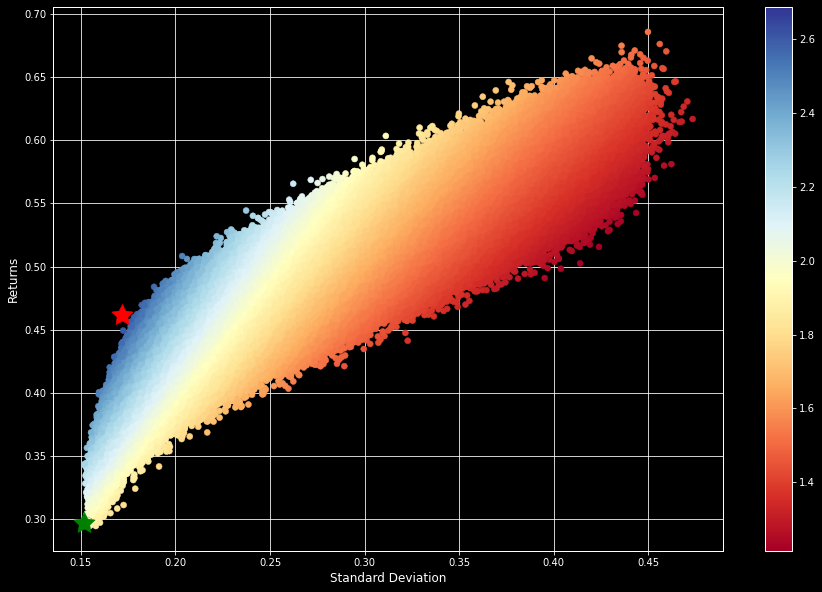

In [21]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()

In [22]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,BIOTON SPOLKA AKCYJNA,STALEXPORT AUTOSTRADY SPOLKA AKCYJNA,SANTANDER BANK POLSKA SPOLKA AKCYJNA,SYNEKTIK SPOLKA AKCYJNA,RAWLPLUG SPOLKA AKCYJNA,RAFAKO SPOLKA AKCYJNA,RAINBOW TOURS SPOLKA AKCYJNA,...,ALIOR BANK SPOLKA AKCYJNA,BIO PLANET SPOLKĄ AKCYJNA,SLEEPZ AG,IMMOFINANZ AG,MEDINICE SPOLKA AKCYJNA,INTERFERIE SPOLKA AKCYJNA,NANOGROUP SPOLKA AKCYJNA,KOSZALIŃSKIE PRZEDSIĘBIORSTWO PRZEMYSLU DRZEWNEGO SPOLKA AKCYJNA,RESBUD SE,EUROHOLD BULGARIA AD
685285,0.461203,0.171661,2.686704,0.004962,0.002683,0.001261,0.002327,0.004044,0.00631,0.007266,...,0.001759,0.005167,0.004327,0.004435,0.002019,0.007246,0.000777,0.000211,0.004448,0.006879


In [23]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,BIOTON SPOLKA AKCYJNA,STALEXPORT AUTOSTRADY SPOLKA AKCYJNA,SANTANDER BANK POLSKA SPOLKA AKCYJNA,SYNEKTIK SPOLKA AKCYJNA,RAWLPLUG SPOLKA AKCYJNA,RAFAKO SPOLKA AKCYJNA,RAINBOW TOURS SPOLKA AKCYJNA,...,ALIOR BANK SPOLKA AKCYJNA,BIO PLANET SPOLKĄ AKCYJNA,SLEEPZ AG,IMMOFINANZ AG,MEDINICE SPOLKA AKCYJNA,INTERFERIE SPOLKA AKCYJNA,NANOGROUP SPOLKA AKCYJNA,KOSZALIŃSKIE PRZEDSIĘBIORSTWO PRZEMYSLU DRZEWNEGO SPOLKA AKCYJNA,RESBUD SE,EUROHOLD BULGARIA AD
526306,0.296734,0.151614,1.957162,0.002242,0.000203,0.005683,0.000292,0.001228,0.00441,0.003619,...,0.001074,0.003734,0.007748,0.005346,0.003467,0.002877,0.005554,0.000384,0.004508,0.006218


In [16]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

rf = 0
mean_returns = data3.pct_change().mean().replace(np.inf, 0)
cov = data3.pct_change().cov().replace(np.inf, 0)

tickers = data.columns.levels[0]

optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T.values

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.01, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  ,
        0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
        0.  , 0.  , 0.  , 0.  , 0.  , 

In [17]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T.values.sum()

1.0

In [18]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
                  )
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_variance = min_variance(mean_returns, cov)
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T.to_numpy()

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
        0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
        0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02,
        0.  , 0.  , 0.03, 0.  , 0.  , 

In [19]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T.to_numpy().sum()

1.0

In [20]:

asset=[]
for i in range(pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T.to_numpy().shape[1]):
    if pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T.to_numpy().squeeze()[i] != 0:
        asset.append(data3.columns.levels[0][i])
  
len(asset)

50

In [21]:
### var calculation
from tqdm import tqdm

def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns.replace(np.inf,0) * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in tqdm(range(num_portfolios)):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

num_portfolios = 1000000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

100%|██████████| 1000000/1000000 [15:24<00:00, 1081.31it/s]


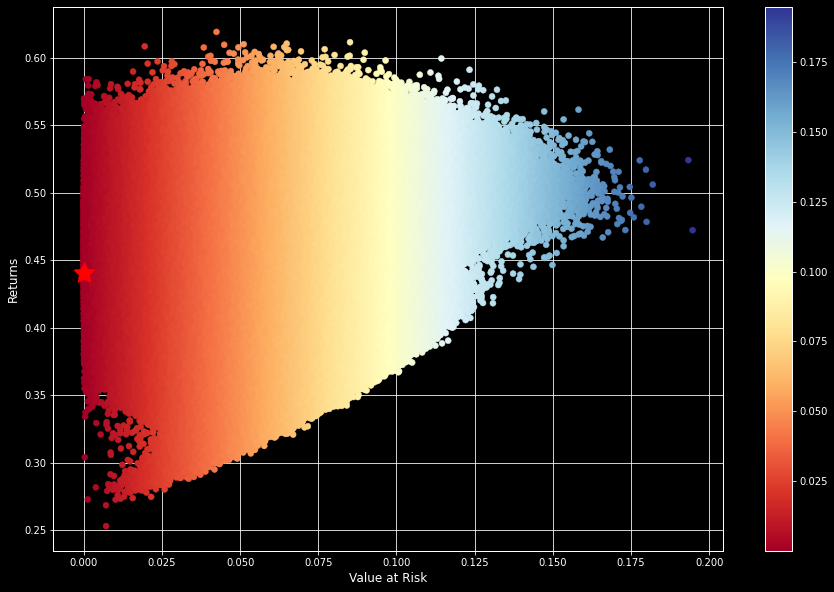

In [22]:
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [23]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,BIOTON SPOLKA AKCYJNA,STALEXPORT AUTOSTRADY SPOLKA AKCYJNA,SANTANDER BANK POLSKA SPOLKA AKCYJNA,SYNEKTIK SPOLKA AKCYJNA,RAWLPLUG SPOLKA AKCYJNA,RAFAKO SPOLKA AKCYJNA,RAINBOW TOURS SPOLKA AKCYJNA,...,CREEPY JAR SPOLKA AKCYJNA,BIO PLANET SPOLKĄ AKCYJNA,SLEEPZ AG,IMMOFINANZ AG,MEDINICE SPOLKA AKCYJNA,INTERFERIE SPOLKA AKCYJNA,NANOGROUP SPOLKA AKCYJNA,KOSZALIŃSKIE PRZEDSIĘBIORSTWO PRZEMYSLU DRZEWNEGO SPOLKA AKCYJNA,RESBUD SE,EUROHOLD BULGARIA AD
5509,0.440671,0.267909,3.542664e-07,0.000805,0.005372,0.005803,0.004925,0.000981,0.006198,0.003926,...,0.005276,0.000708,0.00313,0.005629,0.001297,0.004319,0.007522,0.004108,0.000632,0.006076


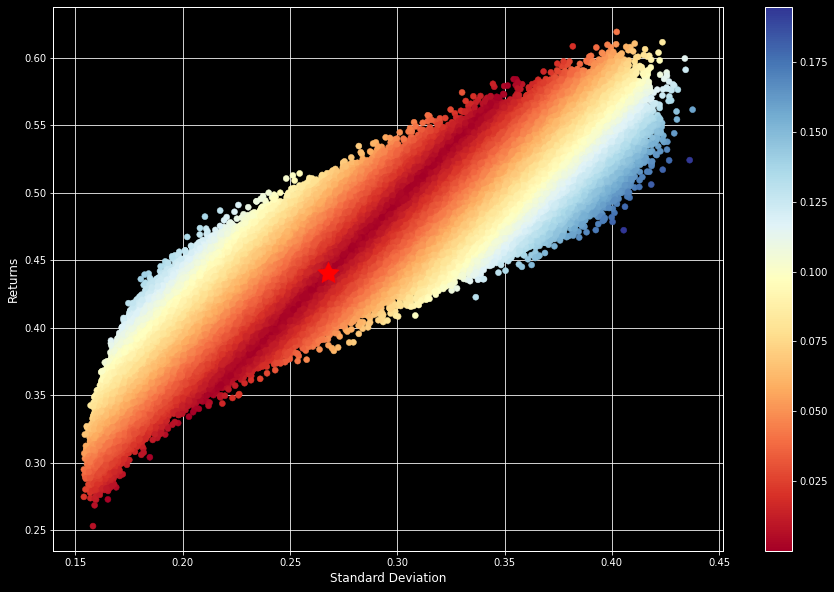

In [24]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [26]:

def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns.replace(np.inf, 0) * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
                   )
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', constraints=constraints, bounds=bounds)
    return result

min_port_VaR = min_VaR(mean_returns, cov, alpha, days)
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T.values

array([[0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.01,
        0.  , 0.01, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.01, 0.  , 0.  , 

In [27]:
from pypfopt import HRPOpt

In [69]:
asset_names = data3.columns.levels[0].tolist()
features = data3.columns.levels[1].tolist()
data4 = pd.DataFrame(data=data3.values, columns=asset_names, index=data3.index).replace(np.inf, 0)
data4 = data4.drop(columns=["EUROHOLD BULGARIA AD"])
mean_returns = data4.pct_change().mean().replace(np.inf, 0)
mean_returns

BIOTON SPOLKA AKCYJNA                                               0.000237
STALEXPORT AUTOSTRADY SPOLKA AKCYJNA                                0.000222
SANTANDER BANK POLSKA SPOLKA AKCYJNA                                0.000256
SYNEKTIK SPOLKA AKCYJNA                                             0.002136
RAWLPLUG SPOLKA AKCYJNA                                             0.001020
                                                                      ...   
MEDINICE SPOLKA AKCYJNA                                             0.002378
INTERFERIE SPOLKA AKCYJNA                                           0.001415
NANOGROUP SPOLKA AKCYJNA                                            0.002860
KOSZALIŃSKIE PRZEDSIĘBIORSTWO PRZEMYSLU DRZEWNEGO SPOLKA AKCYJNA    0.001864
RESBUD SE                                                           0.002928
Length: 261, dtype: float32

In [122]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage


mu = mean_historical_return(data4).replace(np.inf, 0)
huj = CovarianceShrinkage(data4).shrunk_covariance(0.5)

from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, huj)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights(cutoff=0.001)
#print(dict(cleaned_weights))
ef.portfolio_performance(verbose=True)

Expected annual return: 62.8%
Annual volatility: 29.2%
Sharpe Ratio: 2.08


(0.6276113199355258, 0.2924970819271693, 2.077324381946548)

In [125]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(data4)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)

allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'IFIRMA SPOLKA AKCYJNA': 14, 'MOSTOSTAL PLOCK SPOLKA AKCYJNA': 9, 'INVISTA SPOLKA AKCYJNA': 40, 'BUMECH SPOLKA AKCYJNA': 13, 'MILKILAND N.V.': 139, 'MOSTOSTAL ZABRZE SPOLKA AKCYJNA': 136, 'ASBISC ENTERPRISES PLC': 12, 'DATAWALK SPOLKA AKCYJNA': 1, 'BIOMAXIMA SPOLKA AKCYJNA': 7, 'RESBUD SE': 213, 'ERBUD SPOLKA AKCYJNA': 3, 'NEXITY GLOBAL SPOLKA AKCYJNA': 53, 'GETIN HOLDING SPOLKA AKCYJNA': 133, 'MERCATOR MEDICAL SPOLKA AKCYJNA': 2, 'CREEPY JAR SPOLKA AKCYJNA': 1, 'DROZAPOL-PROFIL SPOLKA AKCYJNA': 24, 'ASSECO SOUTH EASTERN EUROPE SPOLKA AKCYJNA': 3, 'KSG AGRO S.A.': 46, 'LIVECHAT SOFTWARE SPOLKA AKCYJNA': 1, 'AUTO PARTNER SPOLKA AKCYJNA': 8, 'KRYNICKI RECYKLING SPOLKA AKCYJNA': 7, 'SYGNITY SPOLKA AKCYJNA': 12, 'COAL ENERGY S.A.': 60, 'HARPER HYGIENICS SPOLKA AKCYJNA': 18, 'KOSZALIŃSKIE PRZEDSIĘBIORSTWO PRZEMYSLU DRZEWNEGO SPOLKA AKCYJNA': 1, 'MIRBUD SPOLKA AKCYJNA': 30, 'GRODNO SPOLKA AKCYJNA': 7, 'BIO PLANET SPOLKĄ AKCYJNA': 5, 'ZPUE SPOLKA AKCYJNA': 1, 'ACTION SPO

In [114]:
mean_returns = data4.pct_change().dropna().replace(np.inf, 0)
hrp = HRPOpt(mean_returns)
hrp_weights = hrp.optimize()

hrp.portfolio_performance(verbose=True)
print(dict(hrp_weights))

Expected annual return: 25.1%
Annual volatility: 12.1%
Sharpe Ratio: 1.91
{'11 BIT STUDIOS SPOLKA AKCYJNA': 0.0020295956982166173, '3RGAMES SPOLKA AKCYJNA': 0.005212670473055636, '4FUN MEDIA SPOLKA AKCYJNA': 0.005887482227996821, 'AB INTER RAO LIETUVA': 0.0032383584265437354, 'AB SPOLKA AKCYJNA': 0.0014827311874865265, 'AC SPOLKA AKCYJNA': 0.009810912473318481, 'ACTION SPOLKA AKCYJNA': 0.001292935285967906, 'ADIUVO INVESTMENTS SPOLKA AKCYJNA': 0.0015152019365853636, 'AGORA SPOLKA AKCYJNA': 0.0010601526296606374, 'AGROTON PUBLIC LIMITED': 0.0008061979865524511, 'AILLERON SPOLKA AKCYJNA': 0.0010298573327532144, 'ALIOR BANK SPOLKA AKCYJNA': 0.0005389840383649537, 'ALL IN! GAMES SPOLKA AKCYJNA': 0.000665230440428591, 'ALTA SPOLKA AKCYJNA': 0.002480540018887938, 'ALTUS SPOLKA AKCYJNA': 0.0025374246851827516, 'ALUMETAL SPOLKA AKCYJNA': 0.0044153153853943175, 'AMBRA SPOLKA AKCYJNA': 0.0026526137842511357, 'AMICA WRONKI SPOLKA AKCYJNA': 0.002122575998972009, 'AMREST HOLDINGS SE': 0.00087275262

In [82]:
import operator

In [85]:
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=10000)

allocation, leftover = da_hrp.greedy_portfolio()
print("Discrete allocation (HRP):", sorted(allocation.items(), key=operator.itemgetter(1), reverse=True))
print("Funds remaining (HRP): ${:.2f}".format(leftover))

Discrete allocation (HRP): [('PRZEDSIĘBIORSTWO PRZEMYSLU SPOŻYWCZEGO PEPEES SPOLKA AKCYJNA', 161), ('SKYLINE INVESTMENT SPOLKA AKCYJNA', 80), ('3RGAMES SPOLKA AKCYJNA', 78), ('ELKOP SPOLKA AKCYJNA', 78), ('ENERGOAPARATURA SPOLKA AKCYJNA', 73), ('RESBUD SE', 62), ('REDAN SPOLKA AKCYJNA', 49), ('BORYSZEW SPOLKA AKCYJNA', 48), ('PATENTUS SPOLKA AKCYJNA', 44), ('PUNKPIRATES SPOLKA AKCYJNA', 39), ('POLWAX SPOLKA AKCYJNA', 37), ('SKOTAN SPOLKA AKCYJNA', 34), ('SERINUS ENERGY INC.', 34), ('KCI SPOLKA AKCYJNA', 31), ('SLEEPZ AG', 30), ('GETIN NOBLE BANK SPOLKA AKCYJNA', 29), ('GRUPA KAPITALOWA IMMOBILE SPOLKA AKCYJNA', 26), ('MUZA SPOLKA AKCYJNA', 25), ('FERRUM SPOLKA AKCYJNA', 24), ('LIBET SPOLKA AKCYJNA', 23), ('SEKO SPOLKA AKCYJNA', 21), ('ATLAS ESTATES LIMITED', 21), ('MDI ENERGIA SPOLKA AKCYJNA', 19), ('SATIS GROUP SPOLKA AKCYJNA', 19), ('ECHO INVESTMENT SPOLKA AKCYJNA', 17), ('ALTUS SPOLKA AKCYJNA', 17), ('INTERSPORT POLSKA SPOLKA AKCYJNA', 17), ('ED INVEST SPOLKA AKCYJNA', 16), ('ZAKLAD

In [101]:
from pypfopt.efficient_frontier import EfficientCVaR

s = data4.cov()
ef_cvar = EfficientCVaR(mu, s)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()


da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=10000)


allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

Discrete allocation (CVAR): {'OPTEAM SPOLKA AKCYJNA': 205, 'AMREST HOLDINGS SE': 65, 'CIECH SPOLKA AKCYJNA': 38, 'OVOSTAR UNION N.V.': 25, 'CD PROJEKT SPOLKA AKCYJNA': 4, 'MABION SPOLKA AKCYJNA': 12, 'ZPUE SPOLKA AKCYJNA': 2, 'SANTANDER BANK POLSKA SPOLKA AKCYJNA': 1, 'STALPRODUKT SPOLKA AKCYJNA': 1, 'AMICA WRONKI SPOLKA AKCYJNA': 1, 'HM INWEST SPOLKA AKCYJNA': 1, 'LSI SOFTWARE SPOLKA AKCYJNA': 1}
Funds remaining (CVAR): $0.50


In [98]:


def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns.replace(np.inf, 0) * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
                   )
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', constraints=constraints, bounds=bounds)
    return result
mean_returns = data4.pct_change().mean().replace(np.inf, 0)
cov = data4.pct_change().cov().replace(np.inf, 0)
alpha =0.05
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=data4.columns).T.values

array([[0.01, 0.  , 0.01, 0.  , 0.  , 0.01, 0.01, 0.  , 0.01, 0.  , 0.01,
        0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.01, 0.01, 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.01,
        0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.  , 0.01, 0.  , 